In [198]:
import random
import numpy as np 

In [199]:
# proporciona información sobre los eventos de la simulación
events = False
# modo debug: muestra información adicional sobre cada evento
verbose = False

#### Parámetros

In [200]:
# Ejemplo del enunciado
T = 30*24*60 # 24h en minutos
# T = 100 #un mes en minutos #pongo 1 dia

nPistas = 3
nCoches = 20
nPuertas = 50

# lambda0 = getlambda0(t)
mu11 = 10.007615178514001
sigma11 = 3.0377002745229005
a12 = 10
b12 = 15
lambda2 = 1/2 # tiempo de traslado exponencial de tasa 30 aviones por hora = 2 minutos por avion
lambda3 = 0.10044207713520997

# T, nCoches, nPuertas, mu11, sigma11, a12, b12, lambda2, lambda3

In [201]:
def getlambda0(t):
    # t está en minutos, convertir a horas:
    t = t/60
    t = t%24 ##########ojo esto##########
    # Intervalo de 0 a 5 horas, lineal de 5 a 7
    if 0 <= t < 5:
        return 5 + (7 - 5) * (t - 0) / (5 - 0)
    # Intervalo de 5 a 8 horas, lineal de 7 a 6
    elif 5 <= t < 8:
        return 7 + (6 - 7) * (t - 5) / (8 - 5)
    # Intervalo de 8 a 15 horas, lineal de 6 a 9
    elif 8 <= t < 15:
        return 6 + (9 - 6) * (t - 8) / (15 - 8)
    # Intervalo de 15 a 17 horas, lineal de 9 a 6
    elif 15 <= t < 17:
        return 9 + (6 - 9) * (t - 15) / (17 - 15)
    # Intervalo de 17 a 24 horas, lineal de 6 a 5
    elif 14 <= t <= 24:
        return 6 + (5 - 6) * (t - 17) / (24 - 17)
    # Si el tiempo está fuera del rango de 0 a 24 horas
    else:
        return 10E9  

#### Funciones auxiliares para generación de tiempos

In [202]:
# Funciones auxiliares generacion de tiempos
def t_llegada(t):
    return random.expovariate(getlambda0(t)/60) #nº muy pequeños, tiene sentido?

def t_aterrizaje():
    # return np.random.normal(mu11, sigma11)
    # return random.normalvariate(mu11, sigma11) 
    while True:  # Bucle infinito hasta obtener un número válido
        resultado = random.normalvariate(mu11, sigma11)
        if resultado > 0:  # Comprobar si el resultado es mayor que cero
            return resultado
        
def t_traslado(): #N1- N2
    return random.expovariate(lambda2)

def t_desembarques():
    return random.expovariate(lambda3)

def t_despegue():
    return random.uniform(a12, b12)

#### Variables

In [203]:
t = 0                   # Variable reloj. tiempo asíncrono.
n1 = n2 = n3 = 0        # Variables de estado nº clientes
NLL1 = NLL2 = NLL3 = 0  # Variables contador nº llegadas
NS1 = NS2 = NS3 = 0     # Variables contador nº salidas

# Lista de tiempos de eventos
LISTA = {
    'tLL1': 10E9,   
    'tS1':  [10E9]*nPistas,
    'tS2':  [10E9]*nCoches,
    'tS3':  [10E9]*nPuertas,
    'tSS':  [10E9]*nPistas
}

# Arrays for arrival and departure times
LL1 = []
LL2 = []
LL3 = []
S1 = []
S2 = []
S3 = []

TECA = [] # Tiempos de Entrada a Cola de Aterrizaje
TSCA = [] # Tiempos de Salida de Cola de Aterrizaje
TECD = [] # Tiempos de Entrada a Cola de Despegue
TSCD = [] # Tiempos de Salida de Cola de Despegue

# Colas
esperando_a_despegar = 0
esperando_a_aterrizar = 0
esperando_coche = 0
esperando_puerta = 0

n_max_coches = 0

n_med_n1 = n_med_n2 = n_med_n3 = 0 #nº medio de pistas ocupadas

In [204]:
def reset_variables():
    global t, n1, n2, n3, LISTA
    global NLL1, NLL2, NLL3, NS1, NS2, NS3, LL1, LL2, LL3, S1, S2, S3
    global n_med_n1, n_med_n2, n_med_n3, n_max_coches
    global esperando_a_despegar, esperando_a_aterrizar, esperando_coche, esperando_puerta
    global TECA, TSCA, TECD, TSCD
    
    t = 0                   # Variable reloj. tiempo asíncrono.
    n1 = n2 = n3 = 0        # Variables de estado nº clientes
    NLL1 = NLL2 = NLL3 = 0  # Variables contador nº llegadas
    NS1 = NS2 = NS3 = 0     # Variables contador nº salidas

    # Lista de tiempos de eventos
    LISTA = {
        'tLL1': 10E9,   
        'tS1':  [10E9]*nPistas,
        'tS2':  [10E9]*nCoches,
        'tS3':  [10E9]*nPuertas,
        'tSS':  [10E9]*nPistas
    }

    # Arrays for arrival and departure times
    LL1 = []
    LL2 = []
    LL3 = []
    S1 = []
    S2 = []
    S3 = []

    TECA = [] # Tiempos de Entrada a Cola de Aterrizaje
    TSCA = [] # Tiempos de Salida de Cola de Aterrizaje
    TECD = [] # Tiempos de Entrada a Cola de Despegue
    TSCD = [] # Tiempos de Salida de Cola de Despegue

    # Colas
    esperando_a_despegar = 0
    esperando_a_aterrizar = 0
    esperando_coche = 0
    esperando_puerta = 0

    n_med_n1 = n_med_n2 = n_med_n3 = 0 #nº medio de pistas ocupadas

    # Añadir en reset_variables()
    global n_max_coches
    n_max_coches = 0


    return
    

In [205]:
def calculate_results(t, NLL1, NLL2, NLL3, LL1, LL2, LL3, S1, S2, S3, TECA, TECD, TSCA, TSCD, n_med_n1, n_med_n2, n_med_n3, n_max_coches):
    # Calculate accumulations
    acumulo1 = sum(S1[i] - LL1[i] for i in range(NLL1))
    acumulo2 = sum(S2[i] - LL2[i] for i in range(NLL2))
    acumulo3 = sum(S3[i] - LL3[i] for i in range(NLL3))
    
    t_med_sistema = 2*(acumulo1 / NLL1) + (acumulo2 / NLL2) + (acumulo3 / NLL3)
    
    # Theoretical expected times
    E_aterrizaje = mu11
    E_traslado = 1/lambda2
    E_desembarque = 1/lambda3
    E_despegue = (a12+b12)/2
    tiempo_teorico = E_aterrizaje + E_traslado + E_desembarque + E_despegue
    
    # Average times per node
    t_medio_n1 = acumulo1 / NLL1 if NLL1 > 0 else 0
    t_medio_n2 = acumulo2 / NLL2 if NLL2 > 0 else 0
    t_medio_n3 = acumulo3 / NLL3 if NLL3 > 0 else 0
    
    # Queue waiting times
    t_en_cola_aterrizaje = [TSCA[i] - TECA[i] for i in range(len(TECA))]
    t_en_cola_despegue = [TSCD[i] - TECD[i] for i in range(len(TECD))]
    
    # Average number of planes in queues
    n_med_cola_aterrizaje = sum(t_en_cola_aterrizaje) / t if len(TECA) > 0 else 0
    n_med_cola_despegue = sum(t_en_cola_despegue) / t if len(TECD) > 0 else 0
    
    # Normalize average number of planes
    n_med_n1, n_med_n2, n_med_n3 = n_med_n1/t, n_med_n2/t, n_med_n3/t
    
    # Runway occupation percentage
    porcentaje_oc_pistas = (acumulo1 /(nPistas*t)) * 100
    
    return {
        'tiempo_simulacion': t,
        'aviones_totales': NLL2,
        'max_coches_ocupados': n_max_coches,
        'tiempo_medio_sistema': t_med_sistema,
        'tiempo_teorico_sistema': tiempo_teorico,
        'tiempos_medios': {
            'nodo1': t_medio_n1,
            'nodo2': t_medio_n2,
            'nodo3': t_medio_n3
        },
        'espera_aterrizaje': {
            'medio': sum(t_en_cola_aterrizaje) / len(TECA) if len(TECA) > 0 else 0,
            'maximo': max(t_en_cola_aterrizaje) if len(TECA) > 0 else 0
        },
        'espera_despegue': {
            'medio': sum(t_en_cola_despegue) / len(TECD) if len(TECD) > 0 else 0,
            'maximo': max(t_en_cola_despegue) if len(TECD) > 0 else 0
        },
        'num_medio_aviones': {
            'cola_aterrizaje': n_med_cola_aterrizaje,
            'cola_despegue': n_med_cola_despegue,
            'total_aeropuerto': n_med_n1 + n_med_n2 + n_med_n3 + n_med_cola_aterrizaje + n_med_cola_despegue
        },
        'porcentaje_ocupacion_pistas': porcentaje_oc_pistas
    }

def print_results(results, more_results=True):
    print(f"Tiempo total de simulación: {results['tiempo_simulacion']:.2f}")
    print(f"Aviones totales en la simulación: {results['aviones_totales']}")
    print(f"Numero máximo de coches ocupados a la vez: {results['max_coches_ocupados']}")
    print('=====================================================')
    
    if more_results:
        print(f"Tiempo en Nodo 1 (Aterrizaje o Despegue) - Teórico: {(mu11+(a12+b12)/2)/2:.2f} min | Simulado: {results['tiempos_medios']['nodo1']:.2f} min")
        print(f"Tiempo en Nodo 2 (Traslado) - Teórico: {1/lambda2} min | Simulado: {results['tiempos_medios']['nodo2']:.2f} min")
        print(f"Tiempo en Nodo 3 (Desembarque) - Teórico: {1/lambda3} min | Simulado: {results['tiempos_medios']['nodo3']:.2f} min")
        print(f"Tiempo en sistema total - Teórico: {results['tiempo_teorico_sistema']} min | Simulado: {results['tiempo_medio_sistema']:.2f} min")
        print('=====================================================')
    
    print(f"Tiempo medio de espera de los aviones para aterrizar: {results['espera_aterrizaje']['medio']:.2f}")
    print(f"Tiempo máximo de espera de los aviones para aterrizar: {results['espera_aterrizaje']['maximo']:.2f}")
    print(f"Tiempo medio de espera de los aviones para despegar: {results['espera_despegue']['medio']:.2f}")
    print(f"Tiempo máximo de espera de los aviones para despegar: {results['espera_despegue']['maximo']:.2f}")
    print('=====================================================')
    
    if more_results:
        print(f"Número medio de aviones en cola de aterrizaje: {results['num_medio_aviones']['cola_aterrizaje']:.2f}")
        print(f"Número medio de aviones en cola de despegue: {results['num_medio_aviones']['cola_despegue']:.2f}")
        print(f"Número medio total de aviones en cola: {results['num_medio_aviones']['cola_aterrizaje'] + results['num_medio_aviones']['cola_despegue']:.2f}")
        print('=====================================================')
    
    print(f"Número medio de aviones en el aeropuerto: {results['num_medio_aviones']['total_aeropuerto']:.2f}")
    print('=====================================================')
    print(f"Porcentaje de tiempo que están ocupadas las pistas: {results['porcentaje_ocupacion_pistas']:.2f} %")


#### Rutina de aterrizaje

In [206]:

def rutina_aterrizaje(t_suc):
    global t, n1, n2, n3, LISTA
    global NLL1, NLL2, NLL3, NS1, NS2, NS3, LL1, LL2, LL3, S1, S2, S3
    global n_med_n1, n_med_n2, n_med_n3, n_max_coches
    global esperando_a_despegar, esperando_a_aterrizar, esperando_coche, esperando_puerta
    global TECA, TSCA, TECD, TSCD
    
    # para luego calcular numero medio de clientes
    n_med_n1 += n1 * (t_suc - t) #tiempo trascurrido hasta el suceso * nº aviones
    n_med_n2 += n2 * (t_suc - t)
    n_med_n3 += n3 * (t_suc - t)
    
    # Si tengo pista libre, aterrizo
    if (n1 < nPistas):
        # Actualizo variables contadores
        n1 += 1                     # El avión entra en n1, y ocupa una pista.

        NLL1 += 1                   # Actualizo numero de llegadas al n1
        LL1.append(t_suc)        # Guardo el tiempo de llegada
        
        t = t_suc
        
        Z = t_aterrizaje() #random.normalvariate(mu11, sigma11) #genero tiempo aterrizaje
        LISTA['tS1'][LISTA['tS1'].index(10E9)] = t + Z
        
        if events: print(f'ATERRIZAJE: {n1} pistas ocupadas. Minuto: {t}. Fin de maniobra: {t+Z}')
    
    # si no tengo pista, no aterrizo, me pongo en cola aterrizaje
    else:
        esperando_a_aterrizar+=1
        
        TECA.append(t)      # Guardo el tiempo de entrada en cola

        if events: print(f'ESPERANDO ATERRIZAR: {esperando_a_aterrizar} aviones esperando. Minuto {t}')

    #=========================================================================#

    # Genero tiempo siguente llegada
    Y = t_llegada(t)
    # Compruebo si el siguiente avión llega antes de T
    if (t + Y < T):
        LISTA['tLL1'] = t + Y #añado otro tiempo de llegada
        # print(f'NUEVO AVIÓN: Minuto: {t+Y}')
    else:
        if events: print(f'#### HORIZONTE ALCANZADO: {t+Y} > {T}, no llegan más aviones ####')
        if verbose: print(f'#### n1 = {n1}, n2 = {n2}, n3 = {n3} ####')
        if verbose: print(LISTA)


#### Rutina de traslado

In [207]:
def rutina_traslado(t_suc): 
    # un coche recoge al avión y lo desaloja de la pista (salida de N1)
    global t, n1, n2, n3, LISTA
    global NLL1, NLL2, NLL3, NS1, NS2, NS3, LL1, LL2, LL3, S1, S2, S3
    global n_med_n1, n_med_n2, n_med_n3, n_max_coches
    global esperando_a_despegar, esperando_a_aterrizar, esperando_coche, esperando_puerta
    global TECA, TSCA, TECD, TSCD
    
    n_med_n1 += n1 * (t_suc - t) #tiempo trascurrido hasta el suceso * nº aviones
    n_med_n2 += n2 * (t_suc - t)
    n_med_n3 += n3 * (t_suc - t)
    
    t=t_suc     # Actualizamos tº de simulación
    
    n1 -=1      # El avión sale del nodo 1, y despeja una pista
    
    NS1 += 1
    S1.append(t_suc)
    
    # si hay coches disponibles -> traslado
    if n2 < nCoches:
        
        n2 +=1                  # El avion entra en n2, y ocupa un coche
        n_max_coches = max(n2, n_max_coches)
        
        NLL2 += 1               # Actualizo numero de llegadas al n1
        LL2.append(t)           # Guardo el tiempo de llegada

        # tiempo de salida del N2, que se corresponde con el final del traslado
        Z = t_traslado()
        LISTA['tS2'][LISTA['tS2'].index(10E9)] = t + Z 

        if events: print(f'-TRASLADO: {n2} coches ocupados. Minuto {t}. Fin de traslado {t+Z}')
        
    else: #si no hay coche disponibles 
        esperando_coche +=1 #lo pongo a la cola de ser trasladado
        if events: print('-ESPERANDO COCHE: {esperando_coche} aviones esperando. Minuto {t}')

    if esperando_a_aterrizar > 0: # ahora que se han liberado pistas, atendemos a la cola de aterrizaje
        
        n1+=1                       # El avión en cola entra al n1, ocupa una pista,
        esperando_a_aterrizar -= 1  # y libera su puesto en la cola.

        NLL1 += 1                   # Actualizo numero de llegadas al n1
        LL1.append(t)               # Guardo el tiempo de llegada
        TSCA.append(t)              # Guardo el tiempo de salida de cola

        Z = t_aterrizaje()                              # genero tiempo que tardará en aterrizar
        LISTA['tS1'][LISTA['tS1'].index(10E9)] = t + Z  # registro el tiempo en el que saldrá el avión del nodo 1
        
        if events: print(f'ATERRIZAJE_cola: {n1} pistas ocupadas. Minuto: {t}. Fin de maniobra: {t+Z}')
        
    elif esperando_a_despegar > 0:

        if esperando_a_aterrizar>0: return -1
        
        n1+=1                       # El avión en cola entra al n1, ocupa una pista,
        esperando_a_despegar -=1    # Y libera su puesto en la cola.

        NLL1 += 1                   # Actualizo numero de llegadas al n1
        LL1.append(t)               # Guardo el tiempo de llegada
        TSCD.append(t)              # Guardo el tiempo de salida de cola

        Z = t_despegue()                                    # genero tiempo que tardará en despegar
        LISTA['tSS'][LISTA['tSS'].index(10E9)] = t + Z      # registro el tiempo en el que saldrá el avión del nodo 1

        
        if events: print(f'---DESPEGUE_cola: {n1} pistas ocupadas. Minuto: {t}. Fin de maniobra: {t+Z}')
        

#### Rutina de desembarque

In [208]:
def rutina_desembarque(t_suc): 
    # avion en aeropuerto: desembarcan pasajeros, embarcan los nuevos y traslado a pistas
    global t, n1, n2, n3, LISTA
    global NLL1, NLL2, NLL3, NS1, NS2, NS3, LL1, LL2, LL3, S1, S2, S3
    global n_med_n1, n_med_n2, n_med_n3, n_max_coches
    global esperando_a_despegar, esperando_a_aterrizar, esperando_coche, esperando_puerta
    global TECA, TSCA, TECD, TSCD
    
    n_med_n1 += n1 * (t_suc - t) #tiempo trascurrido hasta el suceso * nº aviones
    n_med_n2 += n2 * (t_suc - t)
    n_med_n3 += n3 * (t_suc - t)
    
    t=t_suc     # Actualizamos tº de simulación
    
    n2 -=1      # El avión sale de n2 y libera su vehículo.

    NS2 +=1         # Actualizo numero de salidas del n2
    S2.append(t)     # Guardo el tiempo de salida
    
    #si hay puertas de embarque disponibles
    if n3 < nPuertas:

        n3 +=1          # El avión entra en n3, y ocupa una puerta

        NLL3 +=1        # Actualizo numero de llegadas al n3
        LL3.append(t)   # Guardo el tiempo de llegada
        
        Z = t_desembarques()
        LISTA['tS3'][LISTA['tS3'].index(10E9)] = t + Z

        if events: print(f'--PUERTA ASIGNADA: {n3} puertas ocupadas. Minuto: {t}. Fin de proceso: {t+Z}')
        
    else: # si no hay puertas disponibles 
        esperando_puerta+=1     # esperando puerta embarque
        if events: print(f'--ESPERANDO PUERTA: {esperando_puerta} aviones esperando. Minuto: {t}')

    # si tengo aviones pendientes de ser trasladados
    if esperando_coche > 0: 

        n2+=1                       # El avión en cola entra al n2, ocupa un coche,
        esperando_coche -= 1        # Y libera su puesto en la cola.

        NLL2 +=1                    # Actualizo numero de llegadas al n2
        LL2.append(t)               # Guardo el tiempo de llegada
        
        Y = t_traslado()
        LISTA['tS2'][LISTA['tS2'].index(10E9)] = t + Y

        if events: print(f'-TRASLADO_cola: {n2} coches ocupados. Minuto {t}. Fin de traslado {t+Z}')

#### Rutina de despegue (vuelta al nodo 1)

In [209]:
def rutina_despegue(t_suc): 
    # sale del nodo 3 y espera a poder salir del sistema (nodo SS)    
    global t, n1, n2, n3, LISTA
    global NLL1, NLL2, NLL3, NS1, NS2, NS3, LL1, LL2, LL3, S1, S2, S3
    global n_med_n1, n_med_n2, n_med_n3, n_max_coches
    global esperando_a_despegar, esperando_a_aterrizar, esperando_coche, esperando_puerta
    global TECA, TSCA, TECD, TSCD
    
    n_med_n1 += n1 * (t_suc - t) #tiempo trascurrido hasta el suceso * nº aviones
    n_med_n2 += n2 * (t_suc - t)
    n_med_n3 += n3 * (t_suc - t)
      
    t=t_suc     # Actualizamos tº de simulación

    n3 -=1      # El avión sale del n3 y libera un puerta.
    
    NS3 += 1        # Actualizo numero de salidas del n3
    S3.append(t)     # Guardo el tiempo de salida

    # Si hay pistas libres
    if n1 < nPistas:
        
        n1+=1               # El avión entra al n1 y ocupa una pista

        NLL1 += 1                   # Actualizo numero de llegadas al n1
        LL1.append(t)               # Guardo el tiempo de llegada

        # generamos tiempo de despegue
        Z = t_despegue()
        LISTA['tSS'][LISTA['tSS'].index(10E9)] = t + Z

        if events: print(f'---DESPEGUE: {n1} pistas ocupadas. Minuto: {t}. Fin de maniobra: {t+Z}')

    else:    
        esperando_a_despegar+=1     # esperando para el despegue
        TECD.append(t)              # Guardo el tiempo de entrada a la cola
        if events: print(f'---ESPERANDO DESPEGAR: {esperando_a_despegar} aviones esperando. Minuto: {t}')

    # Manejo la cola del nodo anterior
    # si quedan aviones esperando puerta
    if esperando_puerta > 0:
        
        n3+=1                   # El avion entra al n3, ocupa una puerta
        esperando_puerta-=1     # Y libera su puesto en la cola

        NLL3 += 1                   # Actualizo numero de llegadas al n3
        LL3.append(t)               # Guardo el tiempo de llegada
        
        Y = t_desembarques()    # Genero tiempo de desembarque
        LISTA['tS3'][LISTA['tS3'].index(10E9)] = t + Y

        if events: print(f'--PUERTA ASIGNADA_cola: {n3} puertas ocupadas. Minuto: {t}. Fin de proceso: {t+Z}')

#### Rutina de salida

In [210]:
def rutina_salida_sistema(t_suc): 
    # sale del nodo 3 y espera a poder salir del sistema (nodo SS)    
    global t, n1, n2, n3, LISTA
    global NLL1, NLL2, NLL3, NS1, NS2, NS3, LL1, LL2, LL3, S1, S2, S3
    global n_med_n1, n_med_n2, n_med_n3, n_max_coches
    global esperando_a_despegar, esperando_a_aterrizar, esperando_coche, esperando_puerta
    global TECA, TSCA, TECD, TSCD
    
    n_med_n1 += n1 * (t_suc - t) #tiempo trascurrido hasta el suceso * nº aviones
    n_med_n2 += n2 * (t_suc - t)
    n_med_n3 += n3 * (t_suc - t)
    
    t=t_suc     # Actualizamos tº de simulación

    n1 -=1      # El avión sale del nodo 1 y despeja una pista.

    NS1 += 1                   # Actualizo numero de salidas del n1
    S1.append(t)                # Guardo el tiempo de salida

    if events: print(f'----SALIDA DE SISTEMA: {n1} pistas ocupadas. Minuto: {t}.')
    if events: print(f'---------------------: Esperando aterrizar: {esperando_a_aterrizar}, Esperando despegar: {esperando_a_despegar}')

    # Manejo la cola del nodo anterior  
    if esperando_a_aterrizar > 0: # ahora que se han liberado pistas, atendemos a la cola de aterrizaje
        Z = t_aterrizaje()                              # genero tiempo que tardará en aterrizar
        LISTA['tS1'][LISTA['tS1'].index(10E9)] = t + Z  # registro el tiempo en el que saldrá el avión del nodo 1
        
        n1+=1                       # El avión en cola entra al n1, ocupa una pista,
        esperando_a_aterrizar -= 1  # y libera su puesto en la cola.

        NLL1 += 1                   # Actualizo numero de llegadas al n1
        LL1.append(t)               # Guardo el tiempo de llegada
        TSCA.append(t)              # Guardo el tiempo de salida de la cola

        if events: print(f'ATERRIZAJE_cola: {n1} pistas ocupadas. Minuto: {t}. Fin de maniobra: {t+Z}')
        
    elif esperando_a_despegar > 0:

        if esperando_a_aterrizar>0: return -1
        
        n1+=1                       # El avión en cola entra al n1, ocupa una pista,
        esperando_a_despegar -=1    # Y libera su puesto en la cola.

        NLL1 += 1                   # Actualizo numero de llegadas al n1
        LL1.append(t)               # Guardo el tiempo de llegada
        TSCD.append(t)              # Guardo el tiempo de salida de la cola

        Z = t_despegue()                                 # genero tiempo que tardará en despegar
        LISTA['tSS'][LISTA['tSS'].index(10E9)] = t + Z  # registro el tiempo en el que saldrá el avión del nodo 1
   
        if events: print(f'---DESPEGUE_cola: {n1} pistas ocupadas. Minuto: {t}. Fin de maniobra: {t+Z}')

# MAIN

In [211]:

def simul_main():
    
    global LISTA, n_med_n1, n_med_n2, n_med_n3, n_max_coches
    global NLL1, NLL2, NLL3, NS1, NS2, NS3, LL1, LL2, LL3, S1, S2, S3
    
    reset_variables()

    # Genero primer evento (aterrizaje)
    X = t_llegada(0)
    
    # Caso especial
    if X > T:
        return
    
    rutina_aterrizaje(X)    

    # Bucle principal
    # While haya eventos pendientes (tiempos en la lista)
    while any(min(val) != 10E9 if isinstance(val, list) else val != 10E9 for val in LISTA.values()):
        min_key = min(
            LISTA.keys(), 
            key=lambda k: min(LISTA[k]) if isinstance(LISTA[k], list) else LISTA[k]
        )
        if verbose: print(LISTA)
        if verbose: print(min_key, LISTA[min_key])
        if verbose: print ()

        if(min_key=='tLL1'): # Si el próximo evento es un aterrizaje (LLN1)
            t_suc=LISTA['tLL1']
            LISTA['tLL1']= 10E9
            rutina_aterrizaje(t_suc)
            
        elif(min_key=='tS1'): # Si el próximo evento es un traslado (SN1)
            t_suc=min(LISTA['tS1'])
            LISTA['tS1'][LISTA['tS1'].index(min(LISTA['tS1']))] = 10E9
            rutina_traslado(t_suc)
            
        elif(min_key=='tS2'): # Si el próximo evento es un deembarque (SN2)
            t_suc=min(LISTA['tS2'])
            LISTA['tS2'][LISTA['tS2'].index(min(LISTA['tS2']))] = 10E9
            rutina_desembarque(t_suc)
            
        elif(min_key=='tS3'): # Si el próximo evento es un deembarque (SN3)
            t_suc=min(LISTA['tS3'])
            LISTA['tS3'][LISTA['tS3'].index(min(LISTA['tS3']))] = 10E9
            rutina_despegue(t_suc)
            
        elif(min_key=='tSS'): # Si el próximo evento es un deembarque (SN4)
            t_suc=min(LISTA['tSS'])
            LISTA['tSS'][LISTA['tSS'].index(min(LISTA['tSS']))] = 10E9
            rutina_salida_sistema(t_suc) 
    
    else:
        if events: print("====No hay más eventos pendientes====\n")
        
    
        # Create results dictionary at the end of the function
        results = calculate_results(t, NLL1, NLL2, NLL3, LL1, LL2, LL3, 
                                    S1, S2, S3, TECA, TECD, TSCA, TSCD, 
                                    n_med_n1, n_med_n2, n_med_n3, n_max_coches)
        
        # print_results(results, more_results=True)
        
        return results


In [ ]:
def run_multiple_simulations(n_sims=1000):
    all_results = []
    
    for _ in range(n_sims):
        results = simul_main()
        if results is not None:
            all_results.append(results)
    
    stats = {}
    
    if len(all_results) > 0:
        metrics = all_results[0].keys()
        
        for metric in metrics:
            if isinstance(all_results[0][metric], dict):
                stats[metric] = {}
                for submetric in all_results[0][metric].keys():
                    values = [sim[metric][submetric] for sim in all_results]
                    mean = sum(values) / len(values)
                    variance = sum((x - mean) ** 2 for x in values) / len(values)
                    stats[metric][submetric] = {
                        'mean': mean,
                        'std': variance ** 0.5  # Square root of variance = std
                    }
            else:
                values = [sim[metric] for sim in all_results]
                mean = sum(values) / len(values)
                variance = sum((x - mean) ** 2 for x in values) / len(values)
                stats[metric] = {
                    'mean': mean,
                    'std': variance ** 0.5  # Square root of variance = std
                }
        
        print("\nRESULTS OVER", n_sims, "SIMULATIONS:")
        print("-" * 40)
        for metric, stat in stats.items():
            print(f"{metric}:")
            if isinstance(stat, dict) and 'mean' in stat:
                print(f"    Mean: {stat['mean']:.4f},       Std: {stat['std']:.4f}")
            else:
                for submetric, substat in stat.items():
                    print(f"    {submetric}:  Mean: {substat['mean']:.4f},      Std: {substat['std']:.4f}")
    
    return stats



In [ ]:
import matplotlib.pyplot as plt
def plot_simulation_boxplots(n_sims):
    # Collect data from simulations
    all_results = []
    for _ in range(n_sims):
        results = simul_main()
        if results is not None:
            all_results.append(results)
    
    # Prepare data for plotting by grouping metrics
    grouped_data = {}
    metrics_to_skip = [list(all_results[0].keys())[4]]
    # metrics_to_skip = [list(all_results[0].keys())[0],list(all_results[0].keys())[1],list(all_results[0].keys())[6]]
    
    for metric in all_results[0].keys():
        if metric in metrics_to_skip:
            continue
        if isinstance(all_results[0][metric], dict):
            submetrics_data = {}
            for submetric in all_results[0][metric].keys():
                submetrics_data[submetric] = [sim[metric][submetric] for sim in all_results]
            grouped_data[metric] = submetrics_data
        else:
            grouped_data[metric] = {metric: [sim[metric] for sim in all_results]}
    
    # Calculate layout
    n_metrics = len(grouped_data)
    n_cols = (n_metrics + 2) // 3  # Ceiling division to get number of columns needed
    n_rows = 3
    
    # Create subplots with adjusted size
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))
    axes = axes.flatten()  # Flatten to make indexing easier
    
    # Hide unused subplots
    for idx in range(n_metrics, len(axes)):
        axes[idx].set_visible(False)
    
    for idx, (metric_name, submetrics) in enumerate(grouped_data.items()):
        axes[idx].boxplot(submetrics.values(), labels=submetrics.keys())
        axes[idx].set_title(metric_name)
        axes[idx].set_ylabel('Value')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return grouped_data


# TESTS

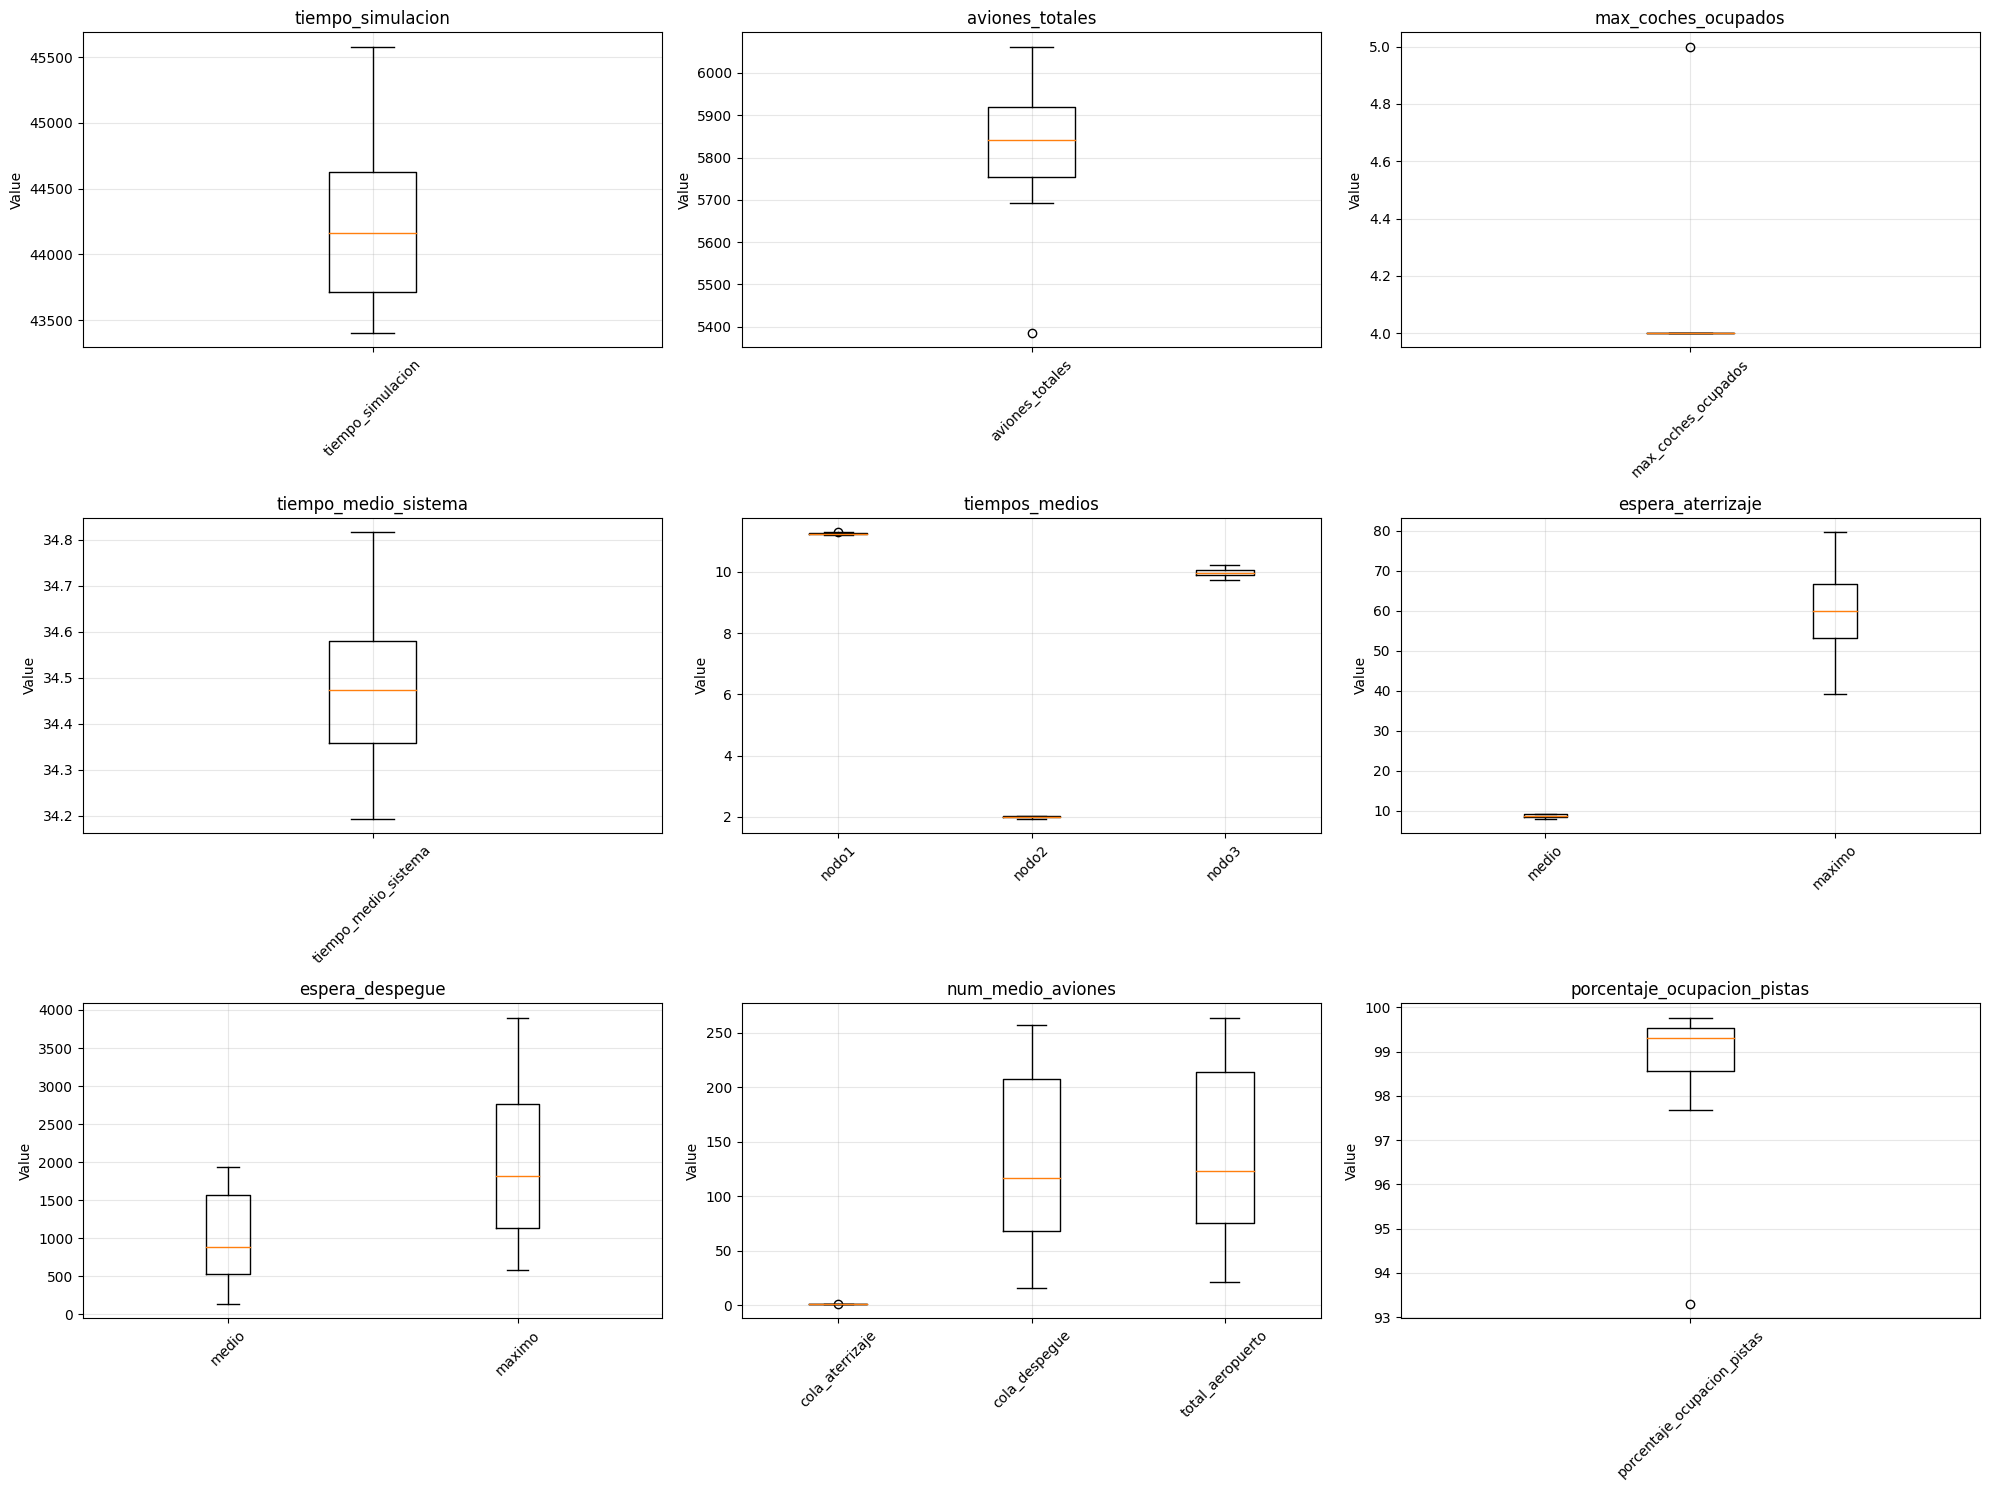

In [214]:
nPistas = 3
nCoches = 20
nPuertas = 50

# simul_main()
# stats = run_multiple_simulations(1000)
data = plot_simulation_boxplots(20)


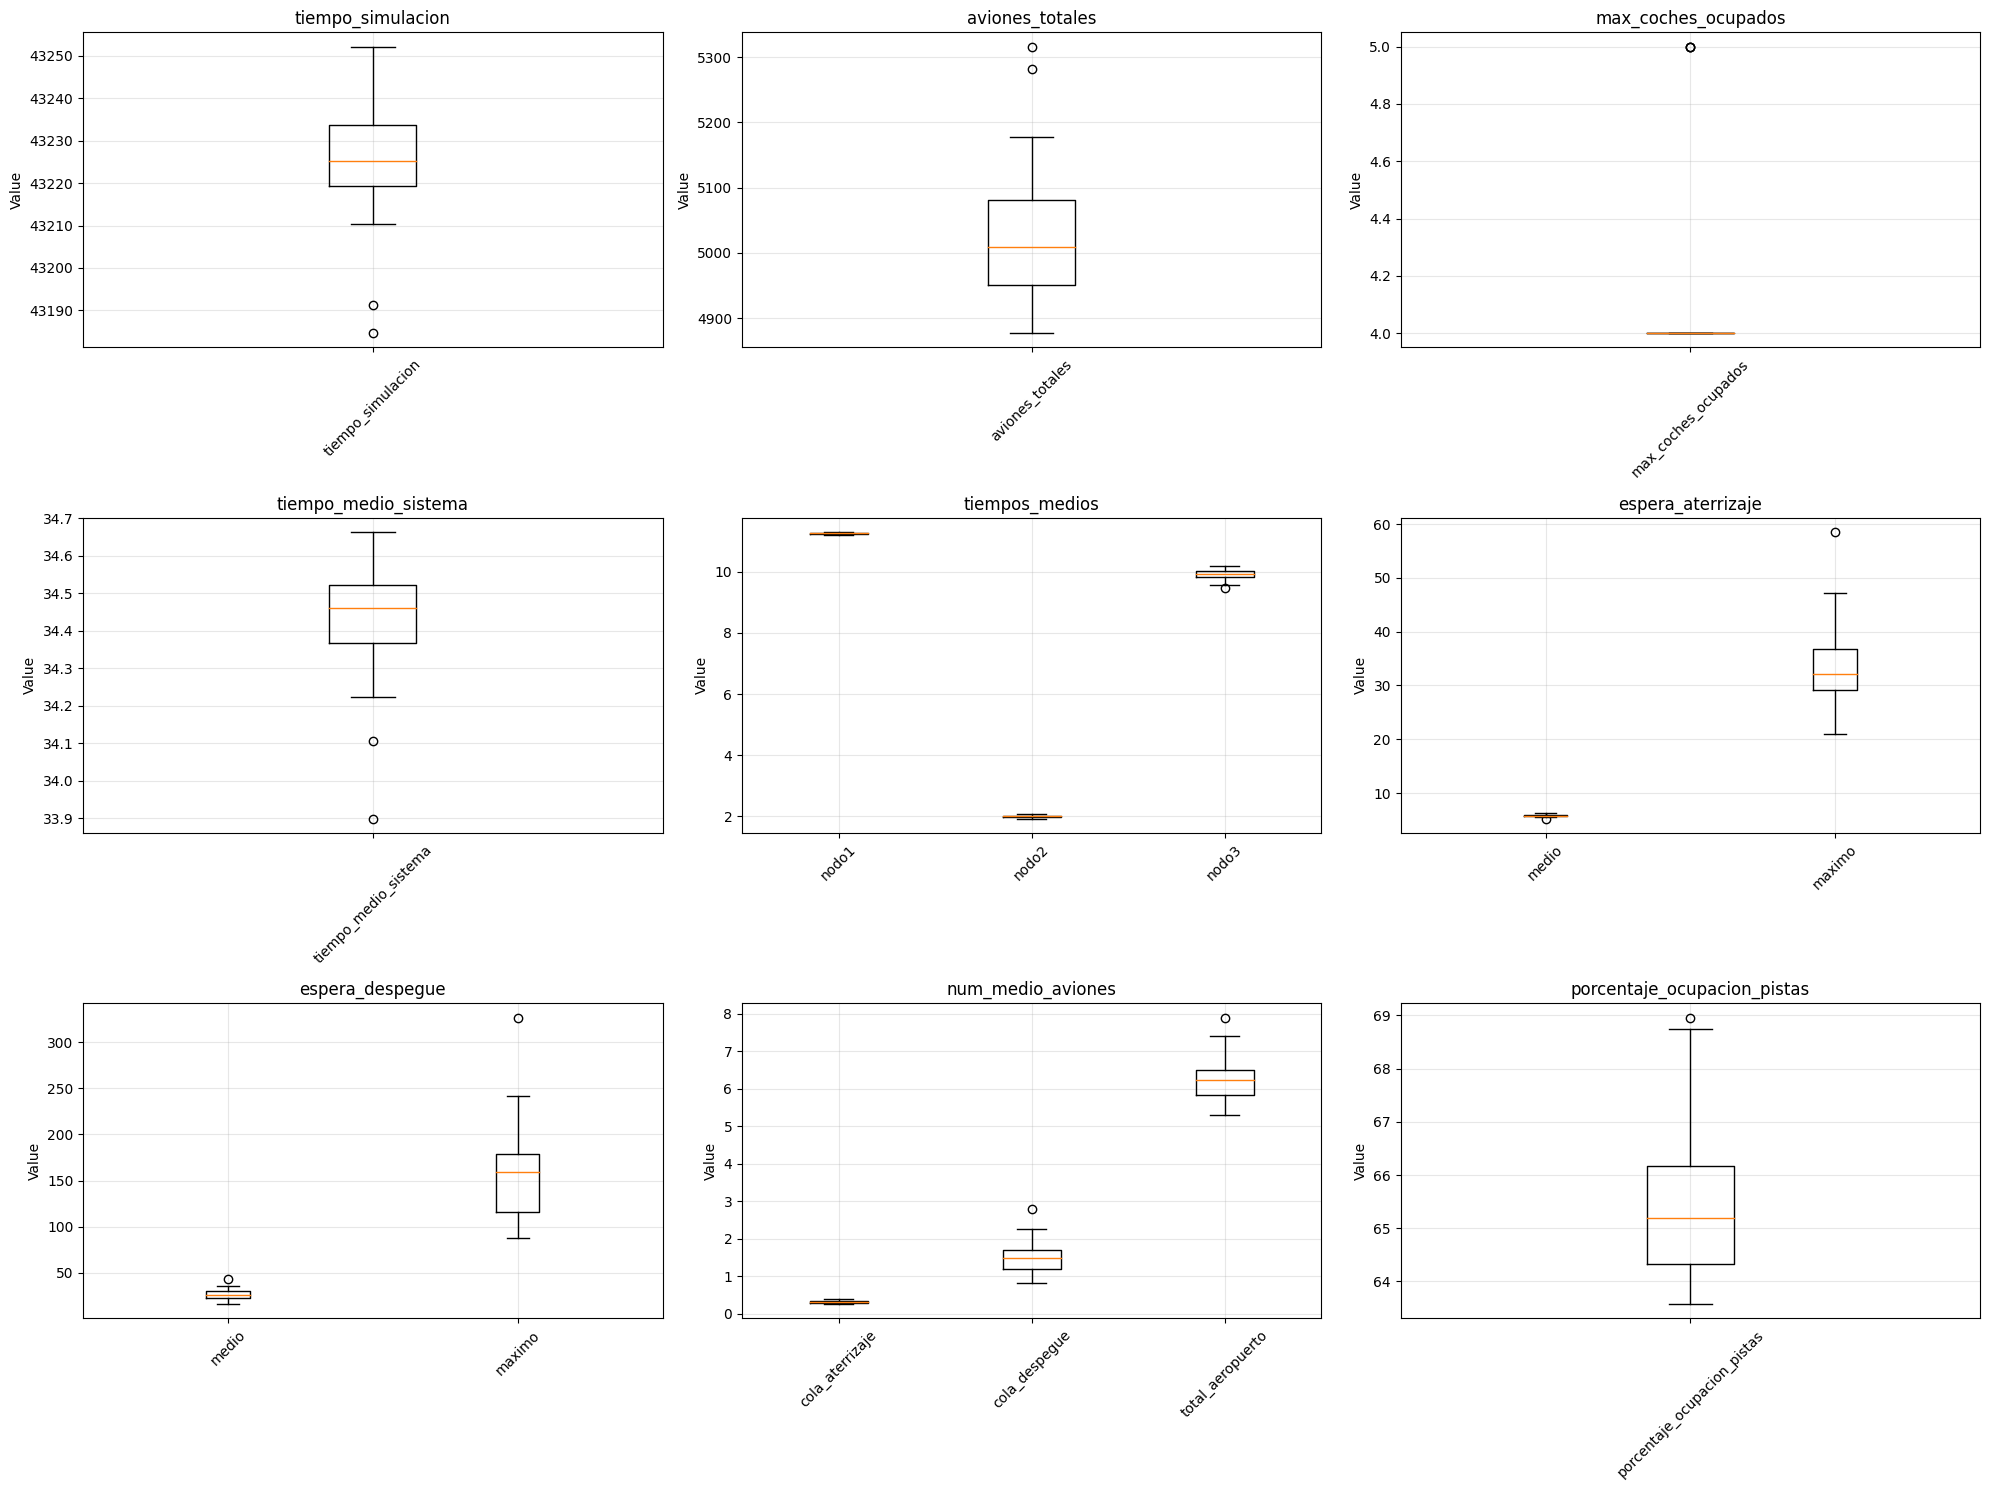

In [215]:
nPistas = 4
nCoches = 20
nPuertas = 50

# simul_main()
# stats = run_multiple_simulations(20)
data = plot_simulation_boxplots(20)

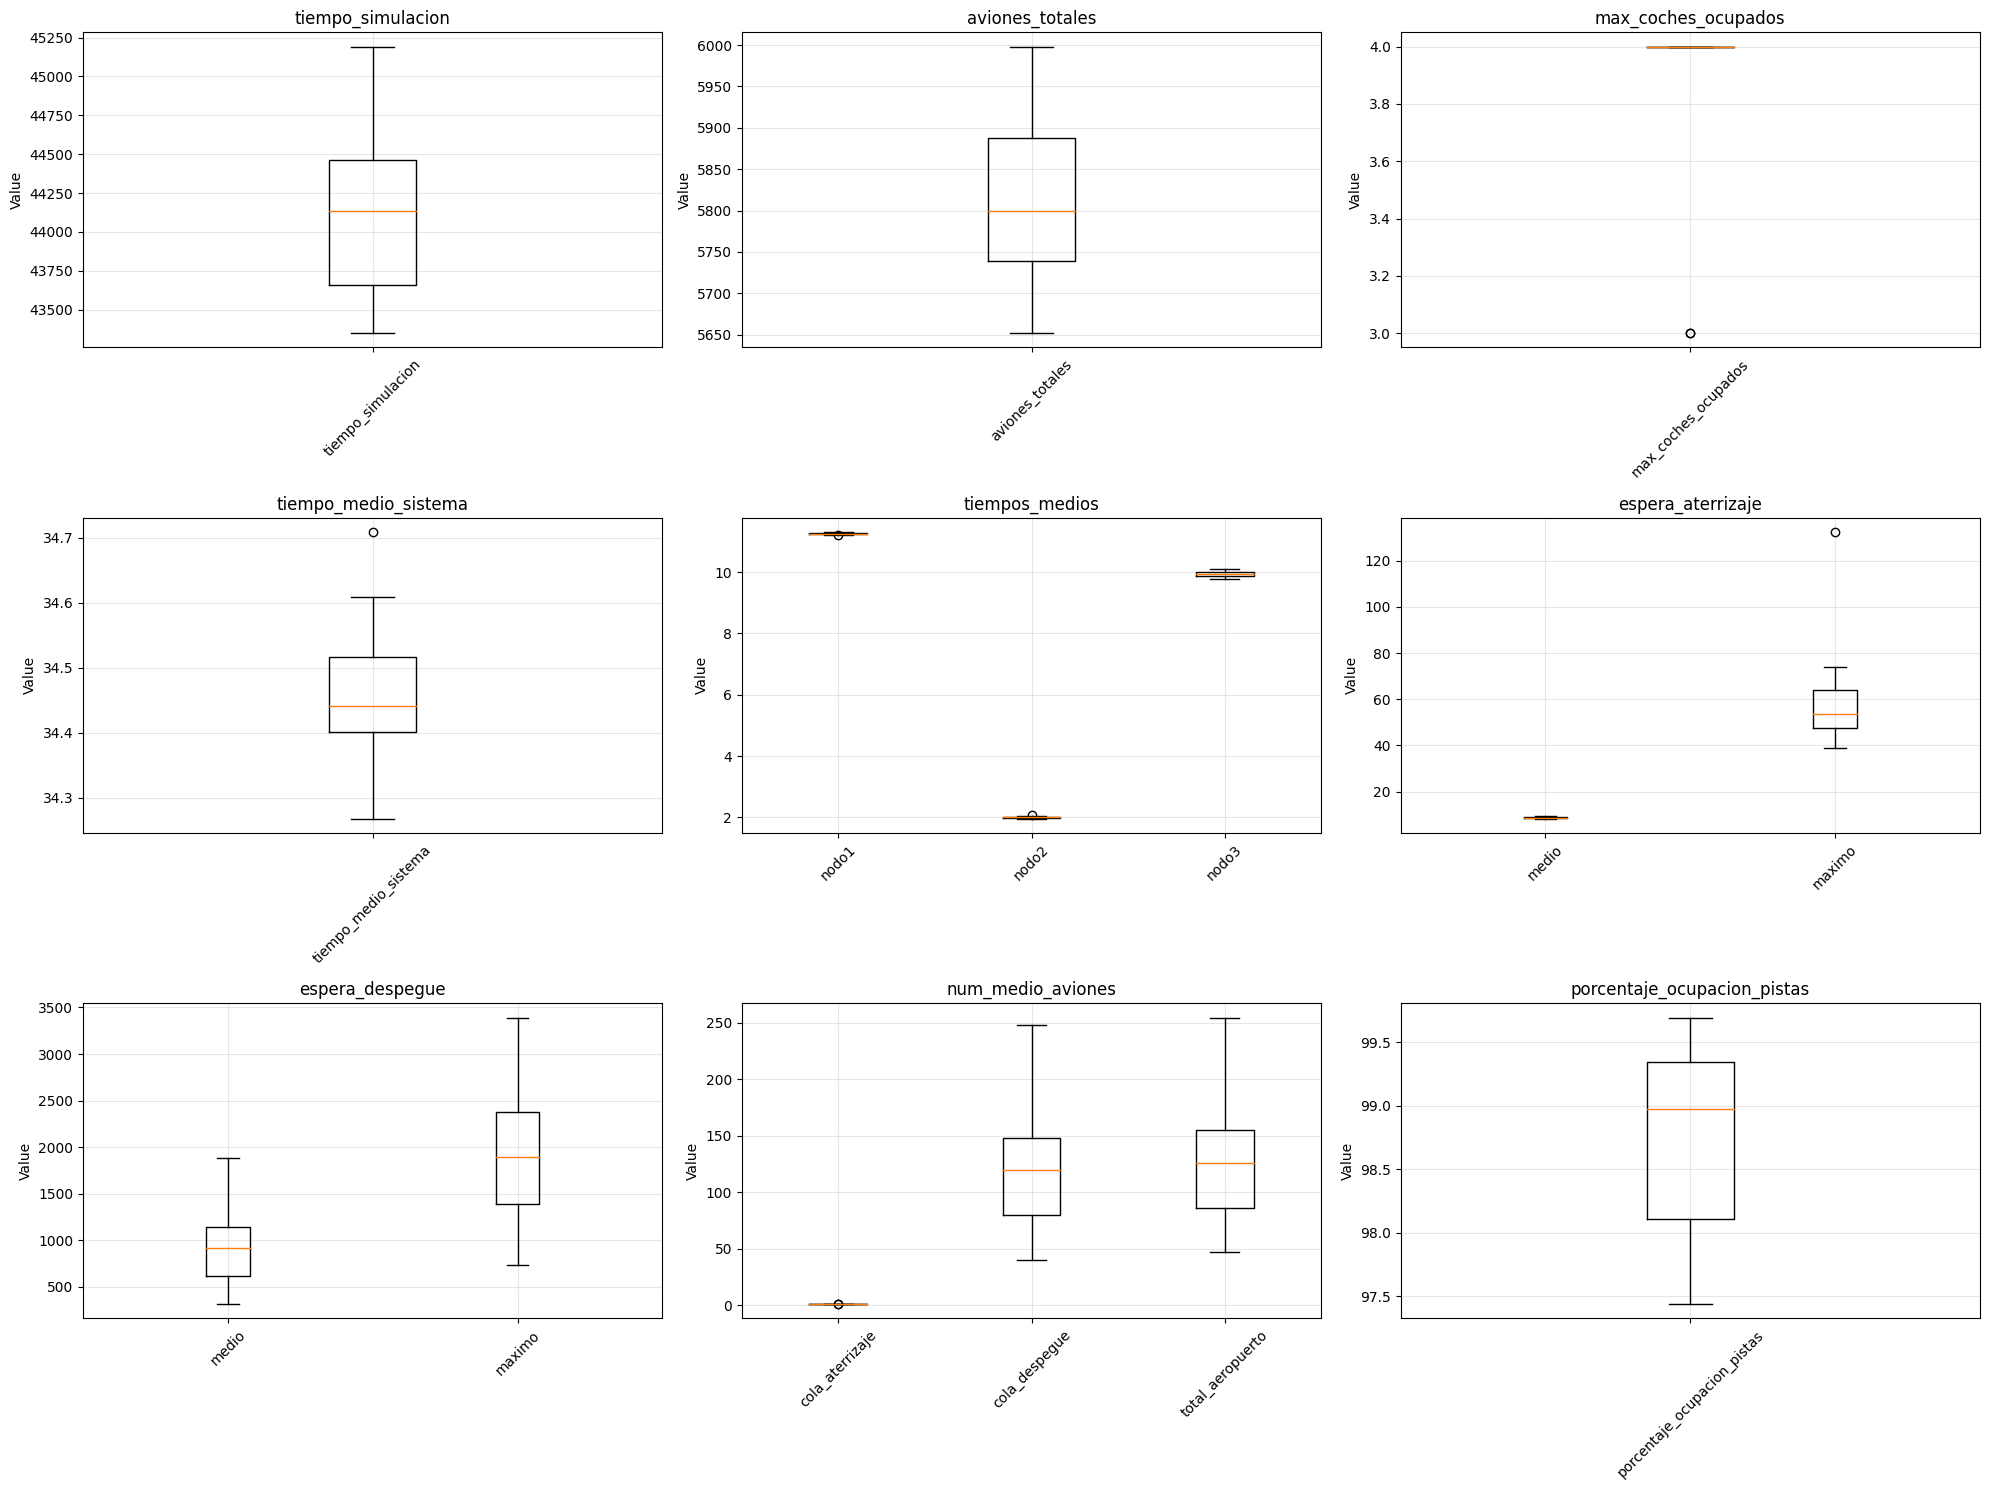

In [216]:
nPistas = 3
nCoches = 25
nPuertas = 50

# simul_main()
# stats = run_multiple_simulations(1000)
data = plot_simulation_boxplots(20)
